In [1]:
import numpy as np
import pickle
import os
from scipy.stats import zscore, spearmanr
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
from sklearn.metrics import auc
import matplotlib
import sys
sys.path.append('..')

from familiarity.familiarization import get_vgg16_pretrained_model_info
from familiarity.commons import get_layers_of_interest
from familiarity.analysis import evaluate_dist_mat
from familiarity.config import DATA_DIR

## Set parameters

In [2]:
nets = [ 'vgg16_random','vgg16_train-imagenet-subset','vgg16_train-vggface2-match-imagenet-subset']
nets_short = ['Randomly initialized','Pretrained on objects',  'Pretrained on faces']

dataset = 'lfw-deepfunneled'

gender = None
batch_size = 64
n_epochs = 50
grow_labels = True
no_freeze_pre_fc = False
bn_freeze = False
save = True
show_figs = True
random_weights = False
recorded_epochs = [0,1,5,10,20,50]
roc_epochs = [0,50]
train_epochs = [1,5,10,20,50]
inverted = False
inverted_test = False
use_softmax = None
dist_met = None 
use_data2 = True

if dataset == 'lfw-deepfunneled':
    id_thresh = 18
    n_val = 10
    max_ids = None
elif dataset == 'vggface2-test':
    id_thresh = 20
    n_val = 19
    max_ids = 100
else:
    id_thresh = 20
    n_val = 19
    max_ids = None 
    
data_dir = os.path.join(DATA_DIR, 'fine_tuning')
fig_dir = '../figures'

In [3]:
## plot training/validation accuracy during fine-tuning
def plot_training(nets, dataset, net_names_short, plot_type='collapsed', data_dir='',
                    gender = None,
                    batch_size = 64,
                    n_epochs = 50,
                    grow_labels = True,
                    no_freeze_pre_fc = False,
                    bn_freeze = False,
                    save = False,
                    show_figs = True,
                    random_weights = False,
                    recorded_epochs = [0,1,5,10,20,50],
                    roc_epochs = [0,50],
                    train_epochs = [1,5,10,20,50],
                    inverted = False,
                    inverted_test = False,
                    use_softmax = None,
                    dist_met = None, 
                    use_data2 = True,
                    thresh_vals = np.arange(0,1,.01),
                 ):
    if dataset == 'lfw-deepfunneled':
        id_thresh = 18
        n_val = 10
        max_ids = None
    elif dataset == 'vggface2-test':
        id_thresh = 20
        n_val = 19
        max_ids = 100
    else:
        id_thresh = 20
        n_val = 19
        max_ids = None 
        
    if net_names_short is None:
        net_names_short = ['' for net in nets]

    gend_tag = ''
    fig_dir = '../figures' 
    true_fn = f'{data_dir}/results/dist_true_val-{n_val}.pkl'
    if dataset == 'gufd':
        gend_tag = '_gender-{}'.format(gender)
        true_fn = f'{data_dir}/results/dist_true_val_GUFD-{gender}.pkl'
    grow_tag = '_grow_labels-True' if grow_labels else ''
    rand_tag = '_random_weights-True' if random_weights else ''
    max_tag = f'_max_ids-{max_ids}'
    invtag = '_inverted_test-True' if inverted_test else '_inverted-True' if inverted else ''
    sm_tag = '_id-softmax' if use_softmax else ''
    dist_tag = f'_dist-metric-{dist_met}' if dist_met else ''
    epochs = recorded_epochs
    
    imset_dir = '../data/imagesets/{}-subset_thresh-{}_val-{}'.format(dataset, id_thresh, n_val)
    if os.path.exists(f'{imset_dir}/train_counts.pkl'):
        with open(f'{imset_dir}/train_counts.pkl', 'rb') as f:
            (train_labels, val_labels, train_counts) = pickle.load(f)
    else:
        image_datasets = {x: datasets.ImageFolder(os.path.join(imset_dir, x)) for x in ['train', 'val']}
        train_labels = [image_datasets['train'].samples[ii][1] for ii in range(len(image_datasets['train']))]
        val_labels = [image_datasets['val'].samples[ii][1] for ii in range(len(image_datasets['val']))]
        train_counts = [np.sum(train_labels == label) for label in np.unique(train_labels)]
        with open(f'{imset_dir}/train_counts.pkl', 'wb') as f:
            pickle.dump((train_labels, val_labels, train_counts), f)
    
    if plot_type == 'summary':
        raise NotImplementedError()
    elif plot_type == 'collapsed':
        fig1, axs1 = plt.subplots(1,len(nets), figsize=(len(nets)*2.5,2.5), sharex=True)
    else:
        fig2, axs2 = plt.subplots(len(nets),len(train_epochs), figsize=(10,1.1*len(nets)*2), sharex=True, sharey=True)

    for n_i, net in enumerate(nets):
        bn_tag = '' if 'bn' not in net else 'bn_freeze-True_' if bn_freeze else 'bn_freeze-False_'
        layers_of_interest, layer_names = get_layers_of_interest(net)
        base_name = 'batch_size-{}_{}dataset-{}_epochs-{}{}{}_id_thresh-{}_im_dim-224{}{}_n_val-{}_net-{}_no_freeze_pre_fc-{}{}{}{}'.format(
                batch_size, bn_tag, dataset, n_epochs, grow_tag, gend_tag, id_thresh, invtag, max_tag, n_val, net,
                no_freeze_pre_fc, rand_tag, sm_tag, dist_tag)
    #     os.makedirs('{}/{}'.format(fig_dir, base_name), exist_ok=True)
        if net == 'vgg_m_face_bn_dag':
            layer_inds_of_interest = [0,1,3,5,6,7,8]
            n_old_ids = 2622
        else:
            layer_inds_of_interest = [0,1,3,5,6,7,8]
            layer_inds_of_interest = [0,1,5,7,8]
            _, n_old_ids = get_vgg16_pretrained_model_info(net, return_n_classes=True)
        
        results_fn = f'{data_dir}/results/{base_name}.pkl'
        with open(results_fn, 'rb') as f:
            results = pickle.load(f)
            
        if plot_type == 'collapsed':
            # plot accuracy across epochs during learning
            ax = axs1[n_i]
            ax.plot(results['train_acc'], label='train', color='r')
            ax.plot(results['val_acc'], label='test', color='k')
            ax.set_ylim([0,1])
            if n_i == len(nets)-1:
                ax.legend(title='image set', loc='right')
            ax.set_xlabel('Epoch')
            if n_i == 0:
                ax.set_ylabel('Accuracy')
            ax.set_title(net_names_short[n_i])
        if plot_type == 'all':
            # plot accuracy for individuals across multiple epochs
            ax_ind = -1
            for epoch_i, epoch in enumerate(epochs):
                if epoch not in train_epochs:
                    continue
                ax_ind += 1
                ax = axs2[n_i, ax_ind]
                train_acc = np.zeros(len(np.unique(train_labels)))
                val_acc = np.zeros_like(train_acc)
                labels = np.unique(train_labels) if epoch == 0 else n_old_ids+np.unique(train_labels)
                for id_i, id_  in enumerate(labels):
                    train_trials = np.nonzero(results['train_labels'][epoch].numpy() == id_)[0]
                    val_trials = np.nonzero(results['val_labels'][epoch].numpy() == id_)[0]
                    train_acc[id_i] = np.mean((results['train_preds'][epoch][train_trials] == results['train_labels'][epoch][train_trials]).numpy())
                    val_acc[id_i] = np.mean((results['val_preds'][epoch][val_trials] == results['val_labels'][epoch][val_trials]).numpy())
                ax.scatter(train_counts, train_acc, alpha=0.5, s=30, facecolors='r', edgecolors='r', label='train')
                ax.scatter(train_counts, val_acc, alpha=0.5, s=30, facecolors='k', edgecolors='k', label='test')
                ax.set_xscale('log')
                ax.set_xlim([2,600])
                ax.set_ylim([-0.1,1.1])
                if ax_ind == np.floor(len(train_epochs)/2) and n_i == len(nets) - 1:
                    ax.set_xlabel('Unique training examples', fontsize='x-large')
                if ax_ind == len(train_epochs) - 1 and n_i == 1:
                    ax.legend(title='image set', loc='center left', bbox_to_anchor=(1, 0.5), fontsize='large')
                if ax_ind == 0:
                    ax.set_ylabel('Accuracy', fontsize='x-large')
                    ax.annotate(net_names_short[n_i].replace(' ', '\n'), xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 8, 0),
                                xycoords=ax.yaxis.label, textcoords='offset points',
                                size='x-large', ha='right', va='center',
                                # fontweight='bold',
                                 multialignment='center')
                if n_i == 0:
                    if ax_ind == 0:
                        # ax.legend(loc='upper left', fontsize='small')
                        if epoch == 0:
                            ax.set_title('Pre-trained', fontsize='x-large')
                        else:
                            ax.set_title('Epoch {}'.format(epoch), fontsize='x-large')
                    else:
                        ax.set_title('Epoch {}'.format(epoch), fontsize='x-large')
                        ax.tick_params(labelleft=False)
                    ax.locator_params(axis='x', numticks=2)
                    ax.tick_params(axis='x', which='both', labelrotation=45)
                    ax.tick_params(axis='x', which='minor', labelsize=8)

    if plot_type == 'collapsed':
        plt.tight_layout()
    if save:
        os.makedirs(f'{fig_dir}/final_plots', exist_ok=True)
        if plot_type == 'collapsed':
            fn = '{}/final_plots/accuracy_all.png'.format(fig_dir)
            fig1.savefig(fn, bbox_inches='tight', dpi=200)
        else:
            fn = '{}/final_plots/accuracy'.format(fig_dir)
            fig2.savefig(fn, bbox_inches='tight', dpi=200)
    if show_figs:
        plt.show()

## Plot accuracy collapsed across identities

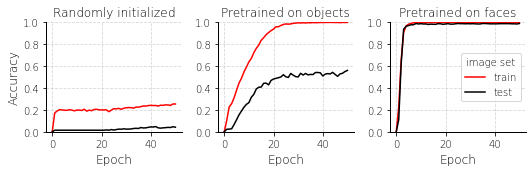

In [4]:
dataset = 'lfw-deepfunneled'
plot_training(nets, dataset, nets_short, save=True, plot_type='collapsed', data_dir=data_dir)

## Plot accuracy for individual identities

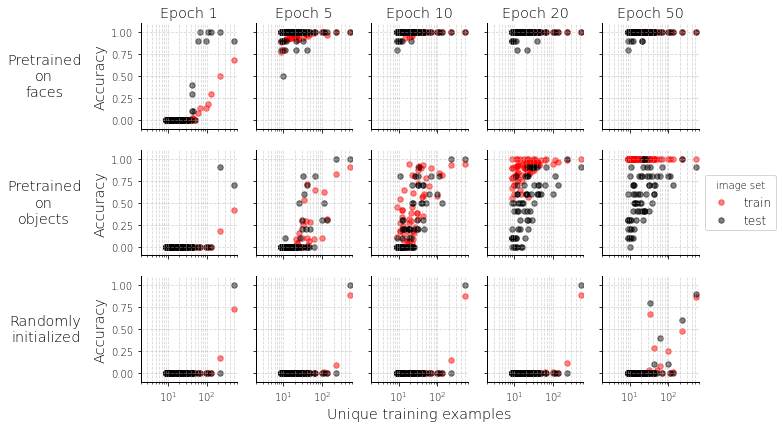

In [5]:
nets = [ 'vgg16_train-vggface2-match-imagenet-subset', 'vgg16_train-imagenet-subset', 'vgg16_random']
nets_short = ['Pretrained on faces', 'Pretrained on objects','Randomly initialized']
dataset = 'lfw-deepfunneled'
plot_training(nets, dataset, nets_short, save=True, plot_type='all', data_dir=data_dir)

## Plot ROC curves collapsed over individuals

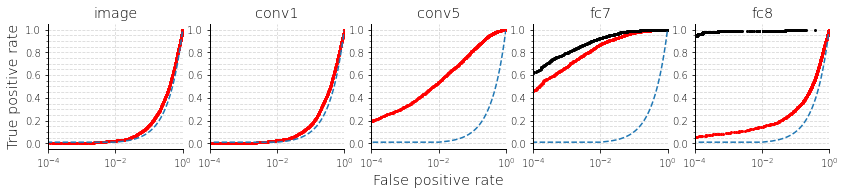

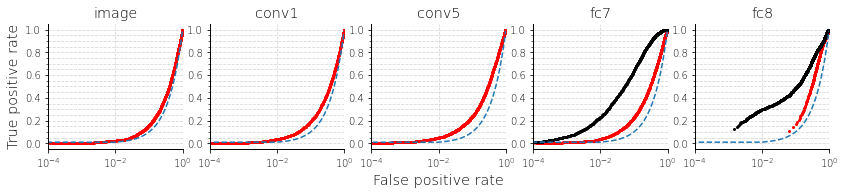

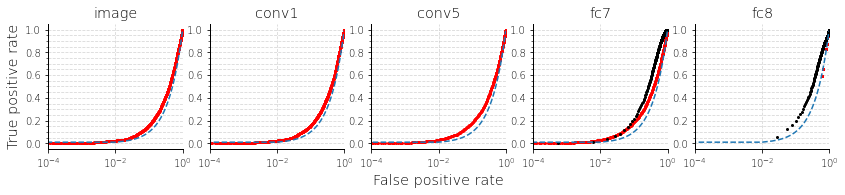

In [6]:
thresh_vals = np.arange(0,1,.01) # for ROC. not be used when tpr and fpr are loaded from earlier
# epochs = np.insert(np.geomspace(1,n_epochs,num=5).round(),0,0).astype(int)

gend_tag = ''
true_fn = f'{data_dir}/results/dist_true_val-{n_val}.pkl'
if dataset == 'gufd':
    gend_tag = '_gender-{}'.format(gender)
    true_fn = f'{data_dir}/results/dist_true_val_GUFD-{gender}.pkl'
grow_tag = '_grow_labels-True' if grow_labels else ''
rand_tag = '_random_weights-True' if random_weights else ''
max_tag = f'_max_ids-{max_ids}'
invtag = '_inverted_test-True' if inverted_test else '_inverted-True' if inverted else ''
sm_tag = '_id-softmax' if use_softmax else ''
dist_tag = f'_dist-metric-{dist_met}' if dist_met else ''


for net_i, net in enumerate(nets):
    bn_tag = '' if 'bn' not in net else 'bn_freeze-True_' if bn_freeze else 'bn_freeze-False_'
    base_name = 'batch_size-{}_{}dataset-{}_epochs-{}{}{}_id_thresh-{}_im_dim-224{}{}_n_val-{}_net-{}_no_freeze_pre_fc-{}{}{}{}'.format(
            batch_size, bn_tag, dataset, n_epochs, grow_tag, gend_tag, id_thresh, invtag, max_tag, n_val, net,
            no_freeze_pre_fc, rand_tag, sm_tag, dist_tag)
    os.makedirs('{}/{}'.format(fig_dir,base_name), exist_ok=True)

    results_fn = f'{data_dir}/results/{base_name}.pkl'
    with open(results_fn, 'rb') as f:
        results = pickle.load(f)

    layers_of_interest, layer_names = get_layers_of_interest(net)
    if net == 'vgg_m_face_bn_dag':
        layer_inds_of_interest = [0,1,3,5,6,7,8]
        n_old_ids = 2622
    else:
        layer_inds_of_interest = [0,1,3,5,6,7,8]
        layer_inds_of_interest = [0,1,5,7,8]
        _, n_old_ids = get_vgg16_pretrained_model_info(net, return_n_classes=True)

    imset_dir = '../data/imagesets/{}-subset_thresh-{}_val-{}'.format(dataset, id_thresh, n_val)
    if os.path.exists(f'{imset_dir}/train_counts.pkl'):
        with open(f'{imset_dir}/train_counts.pkl', 'rb') as f:
            (train_labels, val_labels, train_counts) = pickle.load(f)
    else:
        image_datasets = {x: datasets.ImageFolder(os.path.join(imset_dir, x)) for x in ['train', 'val']}
        train_labels = [image_datasets['train'].samples[ii][1] for ii in range(len(image_datasets['train']))]
        val_labels = [image_datasets['val'].samples[ii][1] for ii in range(len(image_datasets['val']))]
        train_counts = [np.sum(train_labels == label) for label in np.unique(train_labels)]
        with open(f'{imset_dir}/train_counts.pkl', 'wb') as f:
            pickle.dump((train_labels, val_labels, train_counts), f)

    epochs = recorded_epochs

    colors = plt.cm.nipy_spectral(np.linspace(0,1,len(epochs)))
    colors=['r','k']
    fig, axs = plt.subplots(1,len(layer_inds_of_interest),figsize=(14,2.3))
    axs = axs.flatten()
    ax_i = -1
    for l_i, layer in enumerate(layers_of_interest):
        if l_i not in layer_inds_of_interest:
            continue
        ax_i += 1
        ax = axs[ax_i]
        use_epochs = epochs if layer >= layers_of_interest[-3] else [0]
        ep_ind = -1
        for epoch_i, epoch in enumerate(use_epochs):
            if epoch not in roc_epochs:
                continue
            ep_ind+=1
            l_j = l_i if (layer < layers_of_interest[-3] or epoch == 0) else l_i - 6
            if len(roc_epochs) == 2:
                label = 'Unfamiliar' if epoch == 0 else 'Familiarized'
            else:
                label = 'Pre-trained' if epoch == 0 else 'Epoch {}'.format(epoch)
            fpr, tpr = results['val_fpr'][epoch_i][l_j], results['val_tpr'][epoch_i][l_j]
    #         fpr = np.concatenate(([0],fpr,[1]))
    #         tpr = np.concatenate(([0],tpr,[1]))
    #         fpr[fpr==0] = 0.0001
            ax.plot(fpr, tpr, '.', color=colors[ep_ind], label=label, markersize='4')
        ax.plot(np.arange(0,1,.01),np.arange(0,1,.01),'--', label='chance')
        ax.set_xscale('log')
        #    ax.set_yscale('log')
        ax.set_xlim([.0001,1.01])
        #    ax.locator_params(axis='x', numticks=10)
        # ax.tick_params(axis='x', which='both', labelrotation=45)
        # ax.tick_params(axis='x', which='minor', labelsize=8)
        ax.minorticks_on()
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=4)
        ax.xaxis.set_minor_locator(locmin)
        ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
        ax.set_title(layer_names[l_i], fontsize='x-large')
        # ax.tick_params(axis='x', which='minor', labelsize=8)
        if ax_i == np.floor(len(layer_inds_of_interest)/2):
            ax.set_xlabel('False positive rate', fontsize='x-large')
        if ax_i == 0:
            ax.set_ylabel('True positive rate', fontsize='x-large')
        #    else:
        #        ax.yaxis.set_ticklabels([])
        if l_i == len(layers_of_interest) - 1:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='large')
    if save:
        plt.savefig('{}/{}/roc_val_auc_all_layers.png'.format(fig_dir, base_name), bbox_inches='tight')
    if show_figs:
        plt.show()

